In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

この方法はkaggle コンペで王道的な方法です。
This book is royal road　for kaggle competion.

STEP
LGBM + UMAP: Dimension Reduction  + Clustering: Dimension Reduction and Distance  + optuna (all of optimaze)

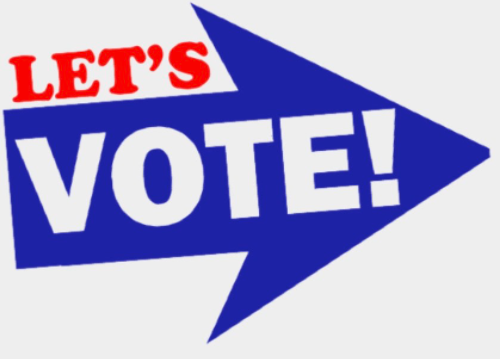

In [ ]:
# Reading files from directory
import os
import pickle
 
# Data manipulation & analysis
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 500)
import datetime as dt
 
import numpy as np
import scipy

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
 
 # 実行に関係ない警告を無視
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import gc
import json
import math

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score,roc_auc_score,log_loss
from sklearn.metrics import mean_squared_error, mean_squared_log_error


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

from lightgbm import LGBMClassifier
import lightgbm

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from colorama import Fore

In [ ]:
#実行環境がどこの階層にあるか、パスを検索
import os
print(os.getcwd())

In [ ]:
train = pd.read_csv("../input/tabular-playground-series-may-2021/train.csv")
test = pd.read_csv("../input/tabular-playground-series-may-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-may-2021/sample_submission.csv")

In [ ]:
display(train.head())
display(train.describe())
display(train.info())

In [ ]:
display(test.head())
display(test.describe())
display(test.info())

In [ ]:
train.columns

In [ ]:
#--------------------------------
#数値の特徴量　※上級者は、特徴量のリストを作成している。
#------------------------------
features_num = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', ]
features_cat = ['target'] 

In [ ]:
##--------------------------------------------
#カテゴリfeature  　ラベルエンコーダー
#---------------------------------------------
for feature in features_cat :
    le = LabelEncoder()
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])

In [ ]:
# 学習データを特徴量と目的変数に分ける  正解ラべルを記入
train_x = train.drop(['target'], axis=1)
train_y = train['target']

# 変数Idを除外する
train_x = train_x.drop(['id'], axis=1)
test_x = test.drop(['id'], axis=1)

In [ ]:
##--------------------------------------------
#カテゴリfeature  標準スケーラー
#---------------------------------------------
from sklearn.preprocessing import LabelEncoder, StandardScaler
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.transform(test_x)

In [ ]:
##--------------------------------------------
#カテゴリfeature  クラスタリング　Kmeans
#---------------------------------------------
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=4 , random_state = 71)
kmeans.fit(train_x)

train_clusters = kmeans.predict(train_x)
test_clusters = kmeans.predict(test_x)

train_distance = kmeans.transform(train_x)
test_distance = kmeans.transform(test_x)

train_distance

In [ ]:
################################################
#  クラスタリング の中心距離を特徴量として、元の特徴量に追加
#######################
train_x= pd.DataFrame(train_x) 
train_1d = pd.DataFrame(train_distance) 
train_1d = train_1d.rename(columns={0: 'Col_1', 1: 'Col_2', 2: 'Col_3', 3: 'Col_4'})

test_x= pd.DataFrame(test_x) 
test_1d = pd.DataFrame(test_distance)
test_1d = test_1d.rename(columns={0: 'Col_1', 1: 'Col_2', 2: 'Col_3', 3: 'Col_4'})

train_1d

In [ ]:
from umap import UMAP
umap_2d = UMAP(n_components=2, random_state=2021)
train_2d = umap_2d.fit_transform(train_x)
test_2d = umap_2d.fit_transform(test_x)

In [ ]:
################################################
#UMAP の次元削減を特徴量として、元の特徴量に追加
#######################
train_x= pd.DataFrame(train_x) 
train_2d = pd.DataFrame(train_2d) 
train_2d = train_2d.rename(columns={0: 'Col_5', 1: 'Col_6'})

train_x2d = pd.concat([train_x,train_1d ,train_2d],axis=1)

test_x= pd.DataFrame(test_x) 
test_2d = pd.DataFrame(test_2d)
test_2d = test_2d.rename(columns={0: 'Col_5', 1: 'Col_6'})

test_x2d = pd.concat([test_x, test_1d , test_2d],axis=1)

In [ ]:
import plotly.express as px

# Take a subsample to reduce computational cost
train_sub = train_2d.sample(1000, random_state=1995)
target_column = 'target'

fig_2d = px.scatter(
    train_sub , x='Col_5', y='Col_6', 
    labels={'color': 'target'},
    #color=train_sub.target,
    color_discrete_sequence = px.colors.qualitative.G10,
)
fig_2d.update_layout(
    title='<span style="font-size:24px; font-family:Serif">UMAP</span>',
)

fig_2d.show()

In [ ]:
## Trial 関数で最適化を探索
##計算量を減らすために、Hold-out法で2:8に分割
##パラメータ探索は重要パラメータをsuggest_int(整数で全部探索) , その他をsuggest_categorical（リスト内を選択）

def objective(trial,data=train_x2d,target=train_y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=71)
    params = {
        'reg_alpha' : trial.suggest_loguniform('reg_alpha' , 1e-2 , 1000),
        'reg_lambda' : trial.suggest_loguniform('reg_lambda' , 1e-2 , 1000),
        'num_leaves' : trial.suggest_int('num_leaves' , 11 , 900),
        'learning_rate' : trial.suggest_float('learning_rate' , 0.0005 , 0.2),
        'max_depth' : trial.suggest_int('max_depth' , 50 , 300),
        'n_estimators' : trial.suggest_int('n_estimators' , 1 ,100000),
        'min_child_samples' : trial.suggest_int('min_child_samples' , 30 , 150),
        'min_child_weight' : trial.suggest_loguniform('min_child_weight' , 1e-5 , 1),
        'subsample' : trial.suggest_float('subsample' , 0.01 , 1.0),
        'colsample_bytree' : trial.suggest_float('colsample_bytree' , 0.01 , 0.8),
    }
    model = LGBMClassifier(**params)  
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],eval_metric='multi_logloss',early_stopping_rounds=100,verbose=False)
        
    preds_opt = model.predict_proba(test_x)
 

    log_loss_multi = log_loss(test_y, preds_opt)
    return log_loss_multi

In [ ]:
import optuna
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize') # or maximize / "minimize"
study.optimize(objective, n_trials=35)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
if OPTUNA_OPTIMIZATION:
    display(optuna.visualization.plot_optimization_history(study))
    display(optuna.visualization.plot_slice(study))

In [ ]:
##############################
#######     LGBMClassifier by tunner
################################

train_oof_lgbm_2d = np.zeros((len(train_x2d), 4))
temp_test = np.zeros((len(test_x2d), 4))


lgbm_params = study.best_trial.params

NUM_FOLDS = 5
kf =  StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=137)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train_x2d, train_y))):
        print(f'Fold {f+1}')
        train_df = train_x2d.iloc[train_ind].reset_index(drop=True)
        val_df = train_x2d.iloc[val_ind].reset_index(drop=True)
        train_target = train_y.iloc[train_ind].reset_index(drop=True)
        val_target = train_y.iloc[val_ind].reset_index(drop=True)

        model = LGBMClassifier(**lgbm_params)
        model =  model.fit(train_df, train_target,eval_set=[(val_df,val_target)],early_stopping_rounds=100,verbose=False)
        
        temp_oof = model.predict_proba(val_df)
        print(log_loss(val_target, temp_oof))
        train_oof_lgbm_2d[val_ind] = temp_oof

        temp_test += model.predict_proba(test_x2d)
        test_preds_lgbm_2d = temp_test/NUM_FOLDS

        
print('All_logloss',log_loss(train_y, train_oof_lgbm_2d))
#np.save('train_oof_lgbm_umap', train_oof_lgbm_umap ) #for validation
#np.save('test_preds_lgbm_umap',test_preds_lgbm_umap ) #for submission

In [ ]:
##### 提出用ファイルの作成 ヘッダー無設の設定
submission = pd.DataFrame( test_preds_lgbm_2d )
submission.columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4']
submission['id'] = test['id']
submission = submission[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4']]

submission.to_csv("submission_lgbm_2d.csv", index=False)
display(submission.head(), submission.tail())